In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('daily_IBM.csv')

In [38]:
df.head()

,timestamp,open,high,low,close,volume
0,2022-01-28,133.19,134.5300,131.790,134.50,5471497
1,2022-01-27,133.66,134.7500,132.080,132.52,5499566
2,2022-01-26,136.47,137.0700,133.130,134.26,8335992
3,2022-01-25,129.14,137.3361,128.300,136.10,19715698
4,2022-01-24,127.99,129.1500,124.193,128.82,13777648


In [39]:
df.tail()

,timestamp,open,high,low,close,volume
5593,1999-11-05,92.75,92.94,90.19,90.25,13737600
5594,1999-11-04,94.44,94.44,90.00,91.56,16697600
5595,1999-11-03,95.87,95.94,93.50,94.37,10369100
5596,1999-11-02,96.75,96.81,93.69,94.81,11105400
5597,1999-11-01,98.50,98.81,96.37,96.75,9551800


In [40]:
df1 = df.reset_index()['close']

In [41]:
print(df1)

0       134.50
1       132.52
2       134.26
3       136.10
4       128.82
         ...  
5593     90.25
5594     91.56
5595     94.37
5596     94.81
5597     96.75
Name: close, Length: 5598, dtype: float64


In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [44]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:1],df1[training_size:len(df1),:1]
train_data,test_data

(array([[0.49418279],
        [0.481864  ],
        [0.4926896 ],
        ...,
        [0.34175325],
        [0.3357805 ],
        [0.33690039]]), array([[0.3473527 ],
        [0.33982455],
        [0.34940584],
        ...,
        [0.24450943],
        [0.24724694],
        [0.25931687]]))

In [45]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [47]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [48]:
len(X_test), len(y_test)

(1859, 1859)

In [50]:
X_train_1 = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test_1 = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train_1, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
111/111 [==============================] - 23s 160ms/step - loss: 0.0188 - val_loss: 0.0011
Epoch 2/10
111/111 [==============================] - 16s 148ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/10
111/111 [==============================] - 16s 147ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/10
111/111 [==============================] - 16s 148ms/step - loss: 0.0012 - val_loss: 9.4349e-04
Epoch 5/10
111/111 [==============================] - 17s 150ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/10
111/111 [==============================] - 17s 150ms/step - loss: 0.0011 - val_loss: 8.0653e-04
Epoch 7/10
111/111 [==============================] - 16s 147ms/step - loss: 9.8155e-04 - val_loss: 8.1321e-04
Epoch 8/10
111/111 [==============================] - 16s 148ms/step - loss: 8.8198e-04 - val_loss: 7.4666e-04
Epoch 9/10
111/111 [==============================] - 16s 148ms/step - loss: 9.6772e-04 - val_loss: 7.2563e-04
Epoch 10/10
111/111 [====================

In [57]:
train_predict=model.predict(X_train_1)
test_predict=model.predict(X_test_1)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [62]:
train_predict

array([[135.5422  ],
       [136.05368 ],
       [136.62932 ],
       ...,
       [116.316895],
       [115.847496],
       [115.26    ]], dtype=float32)

In [63]:
test_predict

array([[97.003105],
       [96.90716 ],
       [96.79652 ],
       ...,
       [96.89396 ],
       [96.1729  ],
       [95.583916]], dtype=float32)

In [58]:
print(len(test_predict))
l = len(df) - len(test_predict)
test = df[l:]
train = df[:l]
len(test)
test['Predictions'] = test_predict

1859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


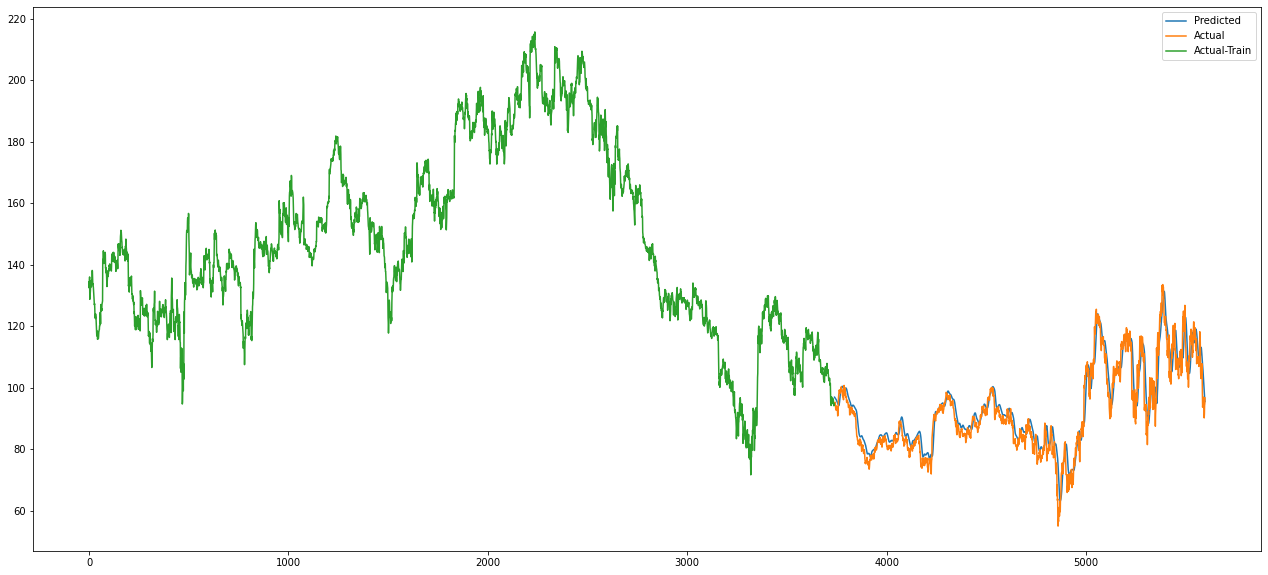

In [61]:
plt.figure(figsize=(22, 10))
plt.plot(test[['Predictions', 'close']])
plt.plot(train.close)
plt.legend(['Predicted', 'Actual', 'Actual-Train'])